# DAT210x - Programming with Python for DS

## Module5- Lab3

In [94]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans

matplotlib.style.use('ggplot') # Look Pretty

A convenience function for you to use:

In [95]:
def clusterInfo(model):
    print("Cluster Analysis Inertia: ", model.inertia_)
    print('------------------------------------------')
    
    for i in range(len(model.cluster_centers_)):
        print("\n  Cluster ", i)
        print("    Centroid ", model.cluster_centers_[i])
        print("    #Samples ", (model.labels_==i).sum()) # NumPy Power

In [96]:
# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_)
    minCluster = 0
    
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()

    print("\n  Cluster With Fewest Samples: ", minCluster)
    return (model.labels_==minCluster)

### CDRs

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) (CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records for 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!

Start by loading up the dataset and taking a peek at its `head` and `dtypes`. You can convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:

In [142]:
# .. your code here ..
df = pd.read_csv('Datasets/CDR.csv')
print(df.head())
df.CallDate = pd.to_datetime(df.CallDate)
df.Duration = pd.to_timedelta(df.Duration)
df.CallTime = pd.to_timedelta(df.CallTime)

#print(df[(df.TowerLat ==32.9000009 ) & (df.TowerLon==-96.90951639)])

           In         Out Direction    CallDate         CallTime  DOW  \
0  4638472273  2666307251  Incoming  2010-12-25  07:16:24.736813  Sat   
1  4638472273  1755442610  Incoming  2010-12-25  21:18:30.053710  Sat   
2  4638472273  5481755331  Incoming  2010-12-25  14:52:42.878016  Sat   
3  4638472273  1755442610  Incoming  2010-12-25  16:02:09.001913  Sat   
4  4638472273  2145623768  Incoming  2010-12-25  15:28:35.028554  Sat   

         Duration                               TowerID   TowerLat   TowerLon  
0  0:02:41.741499  0db53dd3-eb9c-4344-abc5-c2d74ebc3eec  32.731611 -96.709417  
1  0:02:47.108750  aeaf8b43-8034-44fe-833d-31854a75acbf  32.731722 -96.709500  
2  0:04:35.356341  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
3  0:02:23.498499  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
4  0:03:54.692497  95d7920d-c3cd-4d20-a568-9a55800dc807  32.899944 -96.910389  


Create a unique list of the phone number values (people) stored in the `In` column of the dataset, and save them in a regular python list called `unique_numbers`. Manually check through `unique_numbers` to ensure the order the numbers appear is the same order they (uniquely) appear in your dataset:

In [107]:
# .. your code here ..
unique_numbers = list(df.In.unique())
print(unique_numbers)

[4638472273, 1559410755, 4931532174, 2419930464, 1884182865, 3688089071, 4555003213, 2068627935, 2894365987, 8549533077]


Using some domain expertise, your intuition should direct you to know that people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

In [108]:
print("Examining person: ", 0)

Examining person:  0


Create a slice called `user1` that filters to only include dataset records where the `In` feature (user phone number) is equal to the first number on your unique list above:

In [109]:
# .. your code here ..
user1 = df[(df.In == unique_numbers[0])]

Alter your slice so that it includes only Weekday (Mon-Fri) values:

In [110]:
# .. your code here ..
user1 = user1[(user1.DOW != 'Sat') & (user1.DOW != 'Sun') ]

The idea is that the call was placed before 5pm. From Midnight-730a, the user is probably sleeping and won't call / wake up to take a call. There should be a brief time in the morning during their commute to work, then they'll spend the entire day at work. So the assumption is that most of the time is spent either at work, or in 2nd, at home:

In [111]:
# .. your code here ..
user1 = user1[(user1.CallTime < "17:00:00")]
user1.DOW.unique()

array(['Tue', 'Wed', 'Thr', 'Fri', 'Mon'], dtype=object)

Plot the Cell Towers the user connected to

Text(0.5,1,'Weekday Calls before 5PM')

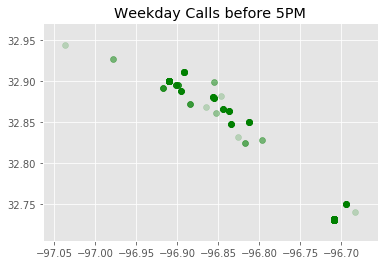

In [112]:
# .. your code here ..
fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(user1.TowerLon,user1.TowerLat, c='g', marker='o', alpha=0.2)

ax.set_title('Weekday Calls before 5PM')

In [121]:
def doKMeans(data, num_clusters=0):
    # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
    # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
    # no feature scaling is required. Print out the centroid locations and add them onto your scatter
    # plot. Use a distinguishable marker and color.
    #
    # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first). This is part
    # of your domain expertise. Also, *YOU* need to create, initialize (and return) the variable named
    # `model` here, which will be a SKLearn K-Means model for this to work:
    
    # .. your code here ..
    
    df1 = pd.concat([data.TowerLat, data.TowerLon], axis = 1)
    kmean = KMeans(n_clusters = num_clusters)
    labels = kmean.fit_predict(df1)
    centroids = kmean.cluster_centers_
    print(centroids)
    model = kmean
    ax.scatter(x=centroids[:,0], y=centroids[:,1], marker='x', c='red', alpha=0.5, linewidths=3, s=169)
    return model

Let's tun K-Means with `K=3` or `K=4`. There really should only be a two areas of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another), then increase K=5, with the goal being that all centroids except two will sweep up the annoying outliers and not-home, not-work travel occasions. the other two will zero in on the user's approximate home location and work locations. Or rather the location of the cell tower closest to them.....

In [140]:
model = doKMeans(user1,3)

[[ 32.9000009  -96.90951639]
 [ 32.73323174 -96.70816184]
 [ 32.86348712 -96.83818346]]
Empty DataFrame
Columns: [In, Out, Direction, CallDate, CallTime, DOW, Duration, TowerID, TowerLat, TowerLon]
Index: []


Print out the mean `CallTime` value for the samples belonging to the cluster with the LEAST samples attached to it. If our logic is correct, the cluster with the MOST samples will be work. The cluster with the 2nd most samples will be home. And the `K=3` cluster with the least samples should be somewhere in between the two. What time, on average, is the user in between home and work, between the midnight and 5pm?

In [132]:
user1

In         Out Direction   CallDate        CallTime  DOW  \
197    4638472273  5481755331  Incoming 2010-12-28 16:20:11.532130  Tue   
200    4638472273  8180005891  Incoming 2010-12-28 15:27:51.105337  Tue   
248    4638472273  8180005891    Missed 2010-12-29 09:13:35.198987  Wed   
249    4638472273  2145623768  Incoming 2010-12-29 06:02:11.319738  Wed   
250    4638472273  8068555700  Incoming 2010-12-29 13:54:14.724722  Wed   
251    4638472273  8180005891  Incoming 2010-12-29 15:45:52.307534  Wed   
321    4638472273  2145623768  Incoming 2010-12-30 06:26:22.828987  Thr   
323    4638472273  8180005891    Missed 2010-12-30 09:31:15.879551  Thr   
403    4638472273  4217121115  Incoming 2010-12-31 08:29:48.427392  Fri   
406    4638472273  2946222380  Incoming 2010-12-31 08:55:44.522912  Fri   
614    4638472273  7922223441  Incoming 2011-01-03 07:24:37.504329  Mon   
615    4638472273  6250348072  Incoming 2011-01-03 07:16:56.658894  Mon   
616    4638472273  6022767590  Incoming 2011-01-03 16:03:10.997508  Mon   
618    4638472273  2946222380    Missed 2011-01-03 08:46:32.937427  Mon   
619    4638472273  7756914135  Incoming 2011-01-03 07:50:54.789093  Mon   
620    4638472273  7428841195  Incoming 2011-01-03 06:25:35.421417  Mon   
687    4638472273  7428841195  Incoming 2011-01-04 07:58:32.520458  Tue   
821    4638472273  6150928001  Incoming 2011-01-06 08:08:59.437274  Thr   
857    4638472273  2666307251  Incoming 2011-01-07 08:08:49.703855  Fri   
859    4638472273  5455269258  Incoming 2011-01-07 08:25:10.871511  Fri   
860    4638472273  5481755331  Incoming 2011-01-07 08:47:01.480002  Fri   
1089   4638472273  5912117253  Incoming 2011-01-10 15:11:47.144906  Mon   
1090   4638472273  7721472178  Incoming 2011-01-10 07:43:46.267354  Mon   
1091   4638472273  2946222380    Missed 2011-01-10 08:34:24.431061  Mon   
1093   4638472273  7841019020  Incoming 2011-01-10 07:13:47.451106  Mon   
1094   4638472273  7428841195  Incoming 2011-01-10 15:32:06.750649  Mon   
1096   4638472273  8180005891  Incoming 2011-01-10 07:47:24.372195  Mon   
1097   4638472273  8180005891  Incoming 2011-01-10 08:11:39.958063  Mon   
1171   4638472273  7721472178  Incoming 2011-01-11 15:35:14.347927  Tue   
1172   4638472273  7922223441  Incoming 2011-01-11 07:40:49.055404  Tue   
...           ...         ...       ...        ...             ...  ...   
52431  4638472273  2946222380    Missed 2013-02-15 09:19:22.160399  Fri   
52432  4638472273  4551601645    Missed 2013-02-15 14:26:23.240566  Fri   
52433  4638472273  4217121115  Incoming 2013-02-15 07:39:50.636877  Fri   
52434  4638472273  7922223441    Missed 2013-02-15 06:45:18.064203  Fri   
52436  4638472273  7756914135  Incoming 2013-02-15 08:53:28.277193  Fri   
52438  4638472273  4217121115  Incoming 2013-02-15 08:02:42.838669  Fri   
52439  4638472273  5481755331  Incoming 2013-02-15 08:05:48.459334  Fri   
52653  4638472273  7841019020  Incoming 2013-02-18 06:59:43.782682  Mon   
52658  4638472273  2666307251  Incoming 2013-02-18 11:05:30.530280  Mon   
52659  4638472273  8180005891  Incoming 2013-02-18 09:04:09.875097  Mon   
52660  4638472273  2946222380  Incoming 2013-02-18 07:46:58.730624  Mon   
52735  4638472273  8068555700    Missed 2013-02-19 12:26:27.514880  Tue   
52737  4638472273  4551601645    Missed 2013-02-19 11:33:21.023266  Tue   
52738  4638472273  5621270003  Incoming 2013-02-19 12:52:46.457510  Tue   
52739  4638472273  1755442610    Missed 2013-02-19 08:05:38.239715  Tue   
52842  4638472273  2145623768  Incoming 2013-02-21 08:53:20.110089  Thr   
52843  4638472273  7922223441  Incoming 2013-02-21 08:15:05.429605  Thr   
52881  4638472273  7922223441  Incoming 2013-02-22 16:55:07.961312  Fri   
52883  4638472273  8068555700  Incoming 2013-02-22 09:55:01.616595  Fri   
53084  4638472273  6022767590    Missed 2013-02-25 07:07:12.843629  Mon   
53085  4638472273  4551601645  Incoming 2013-02-25 09:18:31.595568  Mon   
53086  4638472273  7428841195  Incoming 

In [138]:
len(midWayClusterIndices)

1405

In [137]:
midWayClusterIndices = clusterWithFewestSamples(model)
midWaySamples = user1[midWayClusterIndices]
print("    Its Waypoint Time: ", midWaySamples.CallTime.mean())


  Cluster With Fewest Samples:  2
    Its Waypoint Time:  0 days 07:49:53.168115


Let's visualize the results! First draw the X's for the clusters:

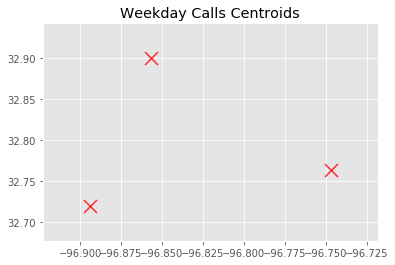

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111)
centroids = model.cluster_centers_
ax.scatter(centroids[:,1], centroids[:,0], s=169, c='r', marker='x', alpha=0.8, linewidths=2)
ax.set_title('Weekday Calls Centroids')
plt.show()